### Deep Backwards Stochastic Differential Equation 

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [ ]:
class QNet(nn.Module):
    def __init__(self, state_dim, hidden_dim=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim+1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1) # Output: trading rate q
        )
    def forward(self, t, y):
        inp = torch.cat([t, y], dim=1) # (batch, 1+state_dim)
        return self.model(inp)
        
class ZNet(nn.Module):
    def __init__(self, state_dim, noise_dim, hidden_dim=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim+1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, noise_dim) # Output: one per Brownian motion
        )
    def forward(self, t, y):
        inp = torch.cat([t, y], dim=1)
        return self.model(inp)


In [8]:
def drift(y, q, mu_P=0.0):
    # y: (batch, 4), q: (batch, 1)
    # returns (batch, 4)
    dX = q
    dP = mu_P * torch.ones_like(q)
    dD = torch.zeros_like(q)
    dB = torch.zeros_like(q)
    return torch.cat([dX, dP, dD, dB], dim=1)

def sigma(batch, t, sigma_P, sigma_D, rho, sigma_B):
    # Returns (batch, 4, 3): 4 state, 3 noise sources (dW^P, d\tilde{W}, dW^B)
    batch_size = batch
    S = torch.zeros(batch_size, 4, 3)
    S[:, 1, 0] = sigma_P # dP, W^P
    S[:, 2, 0] = rho * sigma_D # dD, W^P
    S[:, 2, 1] = (1-rho**2)**0.5 * sigma_D # dD, \tilde{W}
    S[:, 3, 2] = sigma_B # dB, W^B
    return S

def running_cost(y, q, psi=0.5, varphi=0.01):
    # y: (batch, 4) - [X, P, D, B], q: (batch, 1)
    P = y[:, 1:2]
    exec_price = P + psi * torch.sign(q) + varphi * q
    return -q * exec_price


In [9]:
def forward_simulate(y0, N, T, batch_size, q_net, z_net, device, params):
    dt = T / N
    state_dim = y0.shape[1]
    noise_dim = 3
    Y = nn.Parameter(torch.zeros(batch_size, 1, device=device))  # initial value (can be trainable)
    y = y0.clone() # (batch, 4)
    for n in range(N):
        t = torch.full((batch_size, 1), n*dt, device=device)
        q = q_net(t, y) # (batch, 1)
        z = z_net(t, y) # (batch, 3)
        S = sigma(batch_size, t, params['sigma_P'], params['sigma_D'], params['rho'], params['sigma_B']).to(device)
        dW = torch.randn(batch_size, noise_dim, device=device) * dt**0.5  # (batch, 3)
        drift_term = drift(y, q, mu_P=params['mu_P'])
        diffusion = torch.bmm(S, dW.unsqueeze(2)).squeeze(2) # (batch, 4)
        y = y + drift_term * dt + diffusion
        rcost = running_cost(y, q, psi=params['psi'], varphi=params['varphi'])
        Y = Y - rcost * dt + (z * dW).sum(dim=1, keepdim=True)
    # Terminal payoff
    X, P, D, B = y[:,0:1], y[:,1:2], y[:,2:3], y[:,3:4]
    I = X - D
    B_plus = B # You can use the same for simplicity
    B_minus = B
    payoff = torch.clamp(I, min=0)*B_plus - torch.clamp(-I, min=0)*B_minus
    loss = ((Y - payoff)**2).mean()
    return loss


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
q_net = QNet(state_dim=4).to(device)
z_net = ZNet(state_dim=4, noise_dim=3).to(device)

params = {
    'sigma_P': 1.0,
    'sigma_D': 1.0,
    'sigma_B': 1.0,
    'rho': 0.5,
    'mu_P': 0.1,
    'psi': 0.5,
    'varphi': 0.01
}

optimizer = torch.optim.Adam(list(q_net.parameters()) + list(z_net.parameters()), lr=1e-3)
N, T, batch_size = 50, 1.0, 128

for epoch in range(1000):
    y0 = torch.zeros(batch_size, 4, device=device) # Or use random initial state
    loss = forward_simulate(y0, N, T, batch_size, q_net, z_net, device, params)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, loss = {loss.item():.5f}")
    

Epoch 0, loss = 1.36975
Epoch 100, loss = 0.02197
Epoch 200, loss = 0.01982
Epoch 300, loss = 0.02047
Epoch 400, loss = 0.01673
Epoch 500, loss = 0.02201
Epoch 600, loss = 0.02077
Epoch 700, loss = 0.02124
Epoch 800, loss = 0.01812
Epoch 900, loss = 0.01882


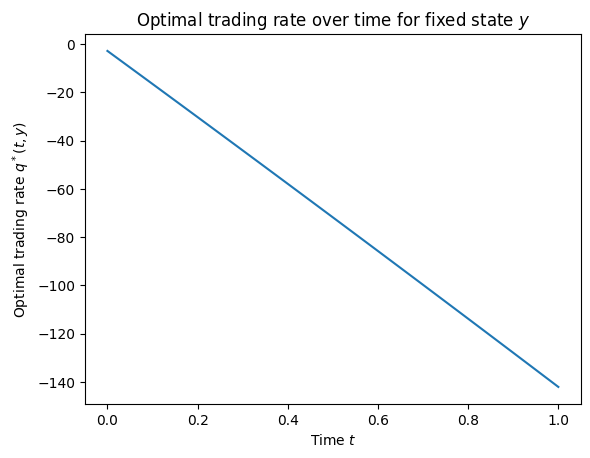

In [ ]:
# Set your fixed state
y_fixed = torch.tensor([[0.0, 50.0, 10.0, 40.0]], device=device, dtype=torch.float32)  # shape (1, state_dim)

# Time grid
T = 1.0
num_times = 50
ts = np.linspace(0, T, num_times)
qs = []

# Evaluate policy across time for fixed y
for t in ts:
    t_tensor = torch.tensor([[t]], device=device, dtype=torch.float32)  # shape (1, 1)
    q_val = q_net(t_tensor, y_fixed)
    qs.append(q_val.item())

plt.plot(ts, np.cumsum(qs))
plt.xlabel("Time $t$")
plt.ylabel("Optimal trading rate $q^*(t, y)$")
plt.title("Optimal trading rate over time for fixed state $y$")
plt.show()

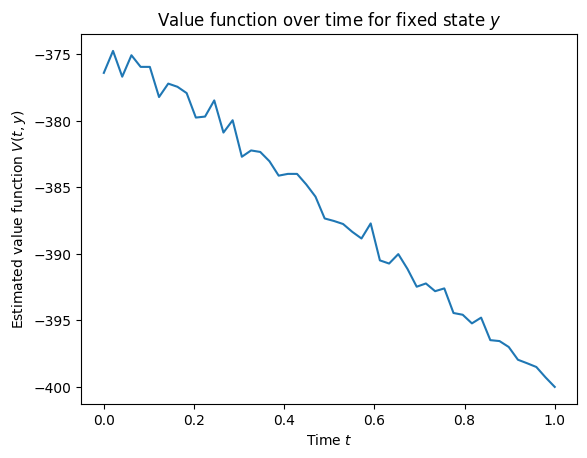

In [23]:
def estimate_value_function(t0, y0, q_net, z_net, params, N, T, n_paths=1000):
    dt = (T - t0) / N
    device = y0.device
    batch_size = n_paths
    state_dim = y0.shape[1]
    noise_dim = 3

    # Initialize
    y = y0.repeat(batch_size, 1) # (batch, 4)
    total_cost = torch.zeros(batch_size, 1, device=device)

    for n in range(N):
        t = torch.full((batch_size, 1), t0 + n*dt, device=device)
        q = q_net(t, y)
        S = sigma(batch_size, t, params['sigma_P'], params['sigma_D'], params['rho'], params['sigma_B']).to(device)
        dW = torch.randn(batch_size, noise_dim, device=device) * dt**0.5
        drift_term = drift(y, q, mu_P=params['mu_P'])
        diffusion = torch.bmm(S, dW.unsqueeze(2)).squeeze(2)
        y = y + drift_term * dt + diffusion
        rcost = running_cost(y, q, psi=params['psi'], varphi=params['varphi'])
        total_cost += rcost * dt

    # Terminal payoff
    X, P, D, B = y[:,0:1], y[:,1:2], y[:,2:3], y[:,3:4]
    I = X - D
    B_plus = B
    B_minus = B
    payoff = torch.clamp(I, min=0)*B_plus - torch.clamp(-I, min=0)*B_minus
    total_cost += payoff
    # Estimate the value function as the mean cost
    V_est = total_cost.mean().item()
    return V_est

V_ts = []
for t in ts:
    V_est = estimate_value_function(t, y_fixed, q_net, z_net, params, N=25, T=T, n_paths=1000)
    V_ts.append(V_est)

plt.plot(ts, V_ts)
plt.xlabel("Time $t$")
plt.ylabel("Estimated value function $V(t, y)$")
plt.title("Value function over time for fixed state $y$")
plt.show()